In [26]:
import operators
from data_management import IPDataset
import config
import torch
import matplotlib.pyplot as plt
import numpy as np

### Device setup

In [27]:
device = torch.device("cuda")

### Dataset setup

In [28]:
test_data = IPDataset("test", config.DATA_PATH)
samples = range(50, 100)
X_0 = torch.stack([test_data[s][0] for s in samples])

In [29]:
X_0.shape

torch.Size([50, 1, 256, 256])

### Plot single image from dataset

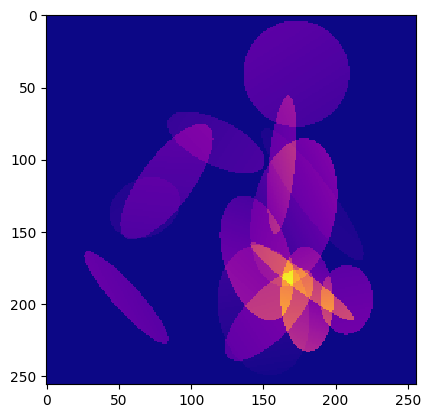

In [52]:
plt.imshow(X_0[0,:,:].squeeze(0), cmap='plasma')

### Initialize wavelet operator

In [31]:
level = 4
input_shape = [256, 256]
W = operators.Wavelet(input_shape, device, level)

In [32]:
W.get_in_shape()

[256, 256]

In [33]:
W.get_out_shape()

(282, 282)

### Test single image and batch processing

In [34]:
X_0.shape

torch.Size([50, 1, 256, 256])

In [35]:
y_single = W.dot(X_0[0,:,:])
y_batch = W.dot(X_0)
print("single output vector shape:", y_single.shape)
print("output vector batch shape:", y_batch.shape)

single output vector shape: torch.Size([79524])
output vector batch shape: torch.Size([50, 79524])


In [36]:
y_single_image = operators.vec2im(y_single, W.get_out_shape())
y_batch_image = operators.vec2im(y_batch, W.get_out_shape())
print("single output image shape:", y_single_image.shape)
print("output image batch shape:", y_batch_image.shape)

single output image shape: torch.Size([282, 282])
output image batch shape: torch.Size([50, 282, 282])


In [37]:
y_single_image_numpy = y_single_image.cpu().detach().numpy()
y_batch_image_numpy = y_batch_image.cpu().detach().numpy()

/tmp/ipykernel_8480/2415444237.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(y_single_image_numpy), interpolation='nearest', cmap='plasma')
/tmp/ipykernel_8480/2415444237.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(y_single_image_numpy), interpolation='nearest', cmap='plasma')


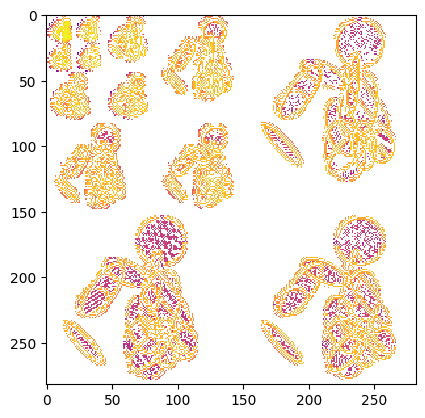

In [51]:
plt.imshow(np.log10(y_single_image_numpy), interpolation='nearest', cmap='plasma')

/tmp/ipykernel_8480/1848251678.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(y_batch_image_numpy[0,:,:]), interpolation='nearest', cmap='plasma')
/tmp/ipykernel_8480/1848251678.py:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(y_batch_image_numpy[0,:,:]), interpolation='nearest', cmap='plasma')


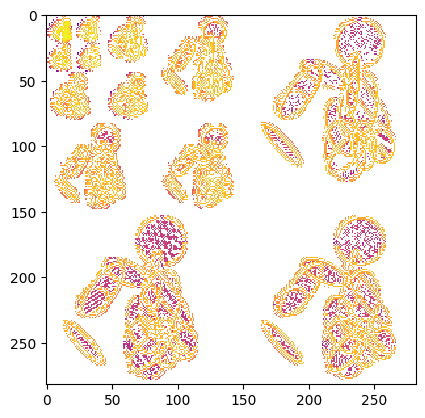

In [47]:
plt.imshow(np.log10(y_batch_image_numpy[0,:,:]), interpolation='nearest', cmap='plasma')

In [40]:
b_batch = W.adj(y_batch)
b_single = W.adj(y_single)
print("computed inverse batch shape:", b_batch.shape)
print("computed inverse single image shape", b_single.shape)

computed inverse batch shape: torch.Size([50, 256, 256])
computed inverse single image shape torch.Size([256, 256])


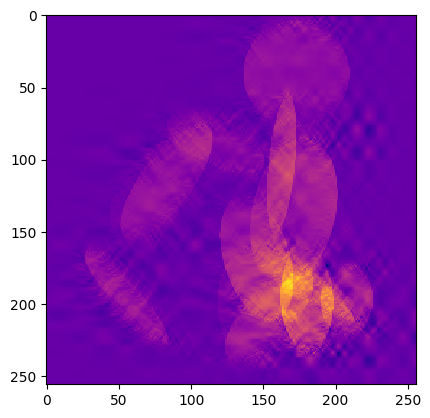

In [50]:
b_single_plot = b_batch[0,:,:].cpu().detach().numpy()
#b_single_plot = np.log10(b_single_plot)
plt.imshow(b_single_plot, cmap='plasma')

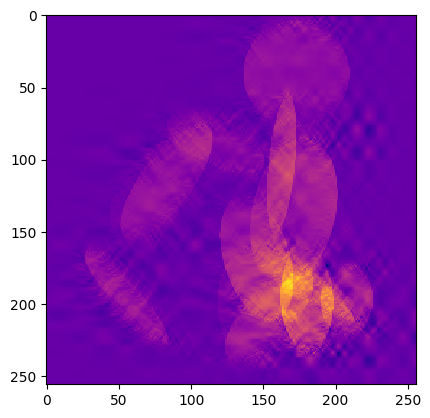

In [53]:
b_batch_plot = b_batch.cpu().detach().numpy()[0,:,:]
plt.imshow(b_batch_plot, cmap='plasma')